In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("../")

from vae_interp.vae import VAE
from vae_interp.sae import SAE
from vae_interp.controls import FeaturesControls
from vae_interp.dataset import load_nouns_dataset, NpyDataset
import matplotlib.pyplot as plt

/home/ubuntu/.cache/pypoetry/virtualenvs/swiggle-H3gdtMpT-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
vae = VAE.load_from_dir("../weights/vae")
# sae = SAE.load_from_checkpoint("../weights/sae/config.json",
#                                "../weights/sae/sae.pth")
sae = SAE.load_from_checkpoint("../checkpoints/sae_experiments_improved/lr=1.0e-04_l1=1.0e-03/config.json",
                               "../checkpoints/sae_experiments_improved/lr=1.0e-04_l1=1.0e-03/sae.pth")

In [4]:
nouns_dataset = load_nouns_dataset(image_size=64, normalize=True)

In [5]:
features_controls = FeaturesControls(
    sae=sae, vae=vae, latent_shape=(4, 4, 4)
)

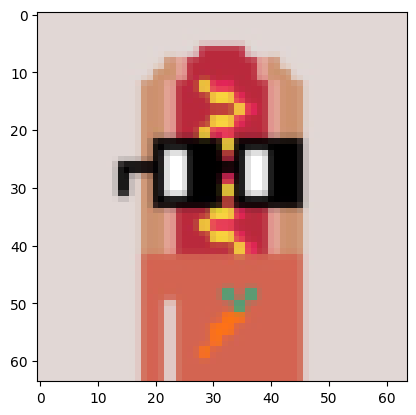

In [6]:
idx = 0
image = nouns_dataset[idx]

plt.imshow((image.permute(1, 2, 0) + 1) * 0.5)

In [7]:
features = features_controls.get_features(image)
features

{38: 0.027438323944807053,
 87: 0.020081866532564163,
 90: 0.36743777990341187,
 142: 0.0868951603770256,
 154: 0.25213852524757385,
 161: 0.008699320256710052,
 162: 0.08411353081464767,
 166: 0.06896832585334778,
 176: 0.12334807962179184,
 199: 0.005904693156480789,
 210: 0.005558142438530922,
 221: 0.006964720785617828,
 232: 0.01649348810315132,
 248: 0.19334112107753754,
 279: 0.02098347246646881,
 281: 0.02229824662208557,
 322: 0.07715727388858795,
 337: 0.07316912710666656,
 354: 0.02262481302022934,
 360: 0.03573502600193024,
 362: 0.23972579836845398,
 377: 0.022377610206604004,
 449: 0.02011403813958168,
 461: 0.01819731667637825,
 468: 1.1741061210632324,
 471: 0.05904035270214081,
 474: 0.0933106541633606,
 488: 0.03915498033165932,
 489: 0.3602377474308014,
 495: 0.00010507926344871521,
 498: 0.008236683905124664,
 519: 0.17240536212921143,
 528: 0.03976462036371231,
 586: 1.2663099765777588,
 588: 0.12236010283231735,
 631: 0.04602595791220665,
 647: 0.04897903278470039

In [8]:
new_features = {**features}
# new_features[202] = 2
# new_features[1] = 3
# new_features[114] = 2
# new_features[497] = 2
# new_features[1] = 2.5
# new_features[197] = 0
# new_features[1019] = 0
new_features

{38: 0.027438323944807053,
 87: 0.020081866532564163,
 90: 0.36743777990341187,
 142: 0.0868951603770256,
 154: 0.25213852524757385,
 161: 0.008699320256710052,
 162: 0.08411353081464767,
 166: 0.06896832585334778,
 176: 0.12334807962179184,
 199: 0.005904693156480789,
 210: 0.005558142438530922,
 221: 0.006964720785617828,
 232: 0.01649348810315132,
 248: 0.19334112107753754,
 279: 0.02098347246646881,
 281: 0.02229824662208557,
 322: 0.07715727388858795,
 337: 0.07316912710666656,
 354: 0.02262481302022934,
 360: 0.03573502600193024,
 362: 0.23972579836845398,
 377: 0.022377610206604004,
 449: 0.02011403813958168,
 461: 0.01819731667637825,
 468: 1.1741061210632324,
 471: 0.05904035270214081,
 474: 0.0933106541633606,
 488: 0.03915498033165932,
 489: 0.3602377474308014,
 495: 0.00010507926344871521,
 498: 0.008236683905124664,
 519: 0.17240536212921143,
 528: 0.03976462036371231,
 586: 1.2663099765777588,
 588: 0.12236010283231735,
 631: 0.04602595791220665,
 647: 0.04897903278470039

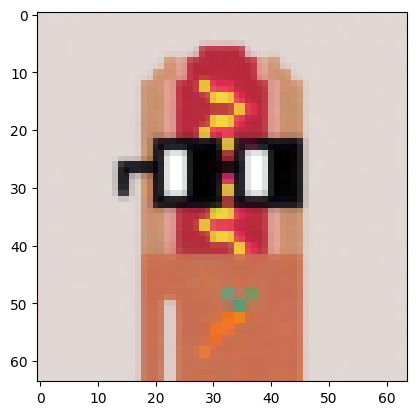

In [9]:
import torch
modified_image = features_controls.modify_features(image, new_features)
# modified_image = (modified_image - modified_image.min()) / (modified_image.max() - modified_image.min())
modified_image = torch.clamp((modified_image + 1) * 0.5, 0, 1)  
modified_image = modified_image.permute(1, 2, 0)

plt.imshow(modified_image)